# EXperiment for CV project
### Section 1: Baseline(realized by these steps: BRG to HSV -> Thresholding -> Morphological Operations -> Connected Component Analysis (CCA))
### Section 2: Baseline + Optimized (Expended the red range, Refine morphological Operations)
### Section 3: Gabor (apply Gabor filtering to the connected regions to extract texture information)
### Section 4: DFT(multi-sacle)
### Section 5: Spixel(Gabor,DFT)
### Section 6: SVM(HOP)
### Section 6: SimpleCNN
### Section 7: Optical(Video)

#### Section1: Baseline

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
def read_to_hsv(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: cannot read picture", image_path)
        return False
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return image,hsv_image

In [30]:
def threshold_process(hsv_image):
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    thred_image = cv2.inRange(hsv_image, lower_red1, upper_red1)
    return thred_image

In [31]:
def Morphological_operation(img):
    kernel = np.ones((5, 5), np.uint8)
    dilated_img = cv2.dilate(img, kernel, iterations=2)
    dilate_erode_img = cv2.erode(dilated_img, kernel, iterations=1)
    return dilate_erode_img

In [32]:
def CCA(img,threshold):
    num_labels, labels, stats, centro = cv2.connectedComponentsWithStats(img, connectivity=8)

    for i in range(1, num_labels):  
        x, y, w, h, area = stats[i]
        if area > threshold:
            return True 

    return False

In [33]:
def detect_fire_in_image(image_path, area_threshold=100):
    _,hsv_image  = read_to_hsv(image_path)
    thred_image = threshold_process(hsv_image)
    morp_image = Morphological_operation(thred_image)
    return CCA(morp_image,area_threshold)

In [34]:
def evaluate_fire_detection(data_dir='data'):


    fire_dir = os.path.join(data_dir, 'fire')
    no_fire_dir = os.path.join(data_dir, 'no_fire')

    TP = 0 
    TN = 0 
    FP = 0 
    FN = 0  

    if os.path.isdir(fire_dir):
        for filename in os.listdir(fire_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(fire_dir, filename)
                has_fire = detect_fire_in_image(image_path) 

                if has_fire:
                    TP += 1
                else:
                    FN += 1
    else:
        print("cannot find dir", fire_dir)


    if os.path.isdir(no_fire_dir):
        for filename in os.listdir(no_fire_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(no_fire_dir, filename)
                has_fire = detect_fire_in_image(image_path)
                if has_fire:
                    FP += 1
                else:
                    TN += 1
    else:
        print("cannot find dir", no_fire_dir)
    total_images = TP + TN + FP + FN
    if total_images == 0:
        return
    
    accuracy = (TP + TN) / total_images

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    if (precision + recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    print("total number of picture:", total_images)
    print("TP:", TP, "TN:", TN, "FP:", FP, "FN:", FN)
    print("Accuracy:" ,accuracy)
    print("Precision: ",precision)
    print("Recall: ",recall)
    print("F1-score: ",f1_score)

    return f1_score

In [35]:
evaluate_fire_detection(data_dir='./CV_FIRE/data')

total number of picture: 206
TP: 110 TN: 13 FP: 83 FN: 0
Accuracy: 0.5970873786407767
Precision:  0.5699481865284974
Recall:  1.0
F1-score:  0.7260726072607261


0.7260726072607261

#### Section1: picture display part

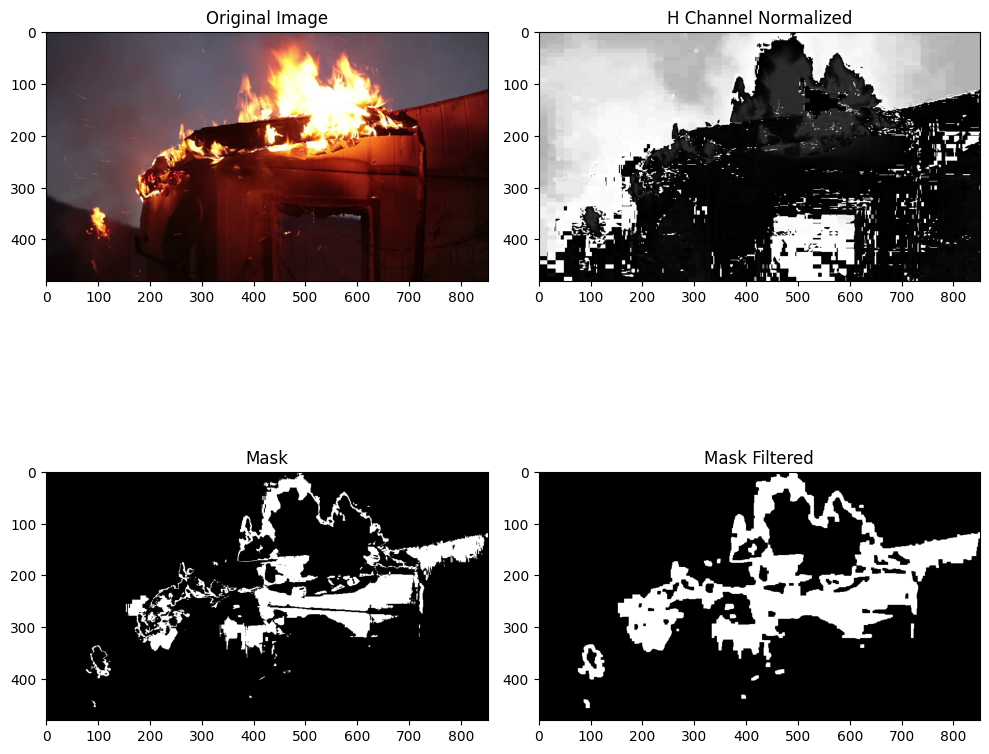

In [36]:
image = cv2.imread('./CV_FIRE/data/fire/fire.jpg')
    

show_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
h_channel = hsv_image[:,:,0]
h_channel_normalized = (h_channel / 179.0) * 255


lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

    
mask = cv2.inRange(hsv_image, lower_red1, upper_red1)

kernel = np.ones((5, 5), np.uint8)
mask_d = cv2.dilate(mask, kernel, iterations=2)
mask_f = cv2.erode(mask_d, kernel, iterations=1)



plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)  
plt.imshow(show_image)
plt.title("Original Image")
plt.subplot(2, 2, 2)  
plt.imshow(h_channel_normalized, cmap='gray')
plt.title("H Channel Normalized")
plt.subplot(2, 2, 3)  
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.subplot(2, 2, 4)  
plt.imshow(mask_f, cmap="gray")
plt.title("Mask Filtered")

plt.tight_layout()
plt.show()

#### Section 2: Baseline + Optimized

- **Expanded Red Range:** Considered both red ranges in HSV: [0, 10] and [160, 180].  
- **Improved Morphological Operations:** Applied "opening" operation (cv2.morphologyEx + cv2.MORPH_OPEN) after thresholding to remove noise, followed by a "closing" operation (cv2.morphologyEx + cv2.MORPH_CLOSE) to fill in "gaps" within the flame region.  
- **More Flexible Area Judgment:** In addition to checking if the area is greater than `area_threshold`, a "maximum area" check was also added as an example to prevent misclassification of a large red background.

In [37]:
def threshold_process_opt(hsv_image):
    lower_red_1 = np.array([0, 100, 100])
    upper_red_1 = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv_image, lower_red_1, upper_red_1)
    lower_red_2 = np.array([160, 100, 100])
    upper_red_2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    thred_image = cv2.bitwise_or(mask1, mask2)
    return thred_image

In [38]:
def Morphological_operation_opt(img):
    kernel = np.ones((5, 5), np.uint8)
    mask_opened_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_closed_img = cv2.morphologyEx(mask_opened_img, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask_closed_img

In [39]:
def detect_fire_in_image(image_path, area_threshold=100):
    _,hsv_image  = read_to_hsv(image_path)
    thred_image = threshold_process_opt(hsv_image)
    morp_image = Morphological_operation_opt(thred_image)
    return CCA(morp_image,area_threshold)

In [40]:
evaluate_fire_detection(data_dir='./CV_FIRE/data')

total number of picture: 206
TP: 106 TN: 31 FP: 65 FN: 4
Accuracy: 0.6650485436893204
Precision:  0.6198830409356725
Recall:  0.9636363636363636
F1-score:  0.7544483985765125


0.7544483985765125

#### Section2: Picture display part: 

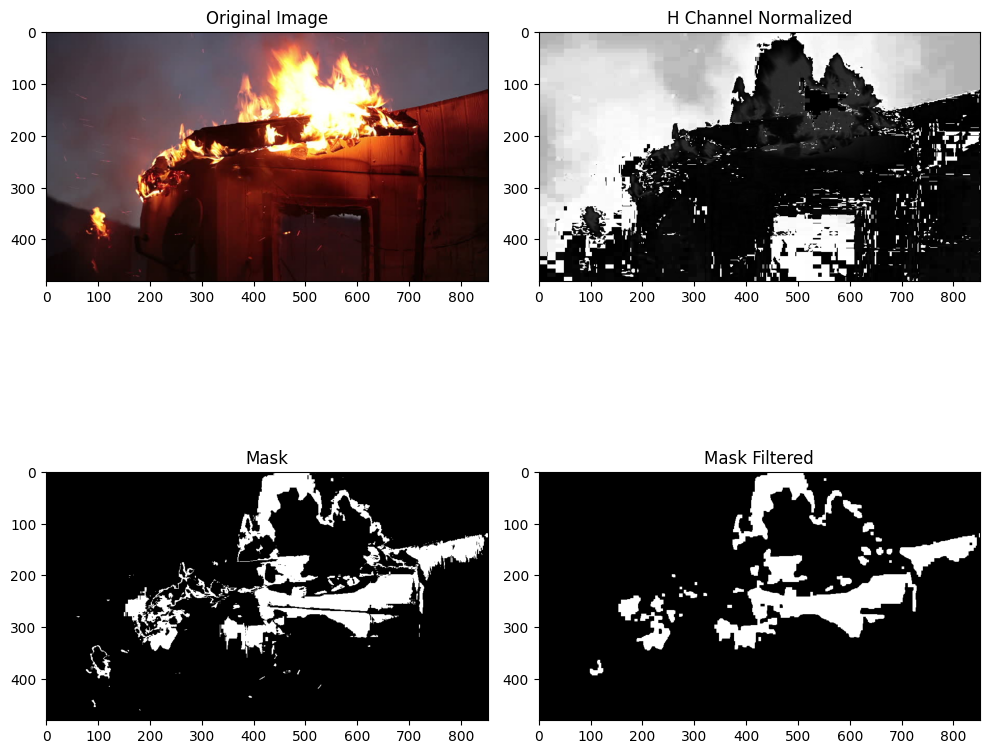

In [41]:
image = cv2.imread('./CV_FIRE/data/fire/fire.jpg')
    

show_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

h_channel = hsv_image[:,:,0]
h_channel_normalized = (h_channel / 179.0) * 255

lower_red_1 = np.array([0, 100, 100])
upper_red_1 = np.array([10, 255, 255])
mask1 = cv2.inRange(hsv_image, lower_red_1, upper_red_1)
lower_red_2 = np.array([160, 100, 100])
upper_red_2 = np.array([180, 255, 255])
mask2 = cv2.inRange(hsv_image, lower_red_2, upper_red_2)
mask = cv2.bitwise_or(mask1, mask2)


kernel = np.ones((5,5), np.uint8)
mask_opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask_closed = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, kernel, iterations=1)


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)  
plt.imshow(show_image)
plt.title("Original Image")
plt.subplot(2, 2, 2)  
plt.imshow(h_channel_normalized, cmap='gray')
plt.title("H Channel Normalized")
plt.subplot(2, 2, 3)  
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.subplot(2, 2, 4)  
plt.imshow(mask_closed, cmap="gray")
plt.title("Mask Filtered")

plt.tight_layout()
plt.show()

In [42]:
def rgb_hsv_chart(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    return image,image_rgb,image_hsv

In [43]:
def CCA_chart(img,rgb_img,threshold):
    num_labels, labels, stats, centro = cv2.connectedComponentsWithStats(img, connectivity=8)
    output_image = rgb_img.copy()
    fire_detected = False
    
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area > threshold:
            fire_detected = True
            cv2.rectangle(output_image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    return fire_detected,output_image

In [44]:
def visual_CCA_result(image_path, area_threshold=100):

    image,rgb_img,hsv_img = rgb_hsv_chart(image_path)
    
    thred_image = threshold_process_opt(hsv_img)
    morp_image = Morphological_operation_opt(thred_image)

    fire_detected,cca_img = CCA_chart(morp_image,rgb_img,area_threshold)
    
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    
    axs[0].imshow(rgb_img)
    axs[0].set_title("orginal chart")
    axs[0].axis("off")
    
    axs[1].imshow(thred_image, cmap='gray')
    axs[1].set_title("thred chart")
    axs[1].axis("off")
    
    axs[2].imshow(morp_image, cmap='gray')
    axs[2].set_title("Morp chart")
    axs[2].axis("off")

    title = "detect result-> we find the fire" if fire_detected else "we don't find the fire"
    axs[3].imshow(cca_img)
    axs[3].set_title(title)
    axs[3].axis("off")
    
    plt.tight_layout()
    plt.show()

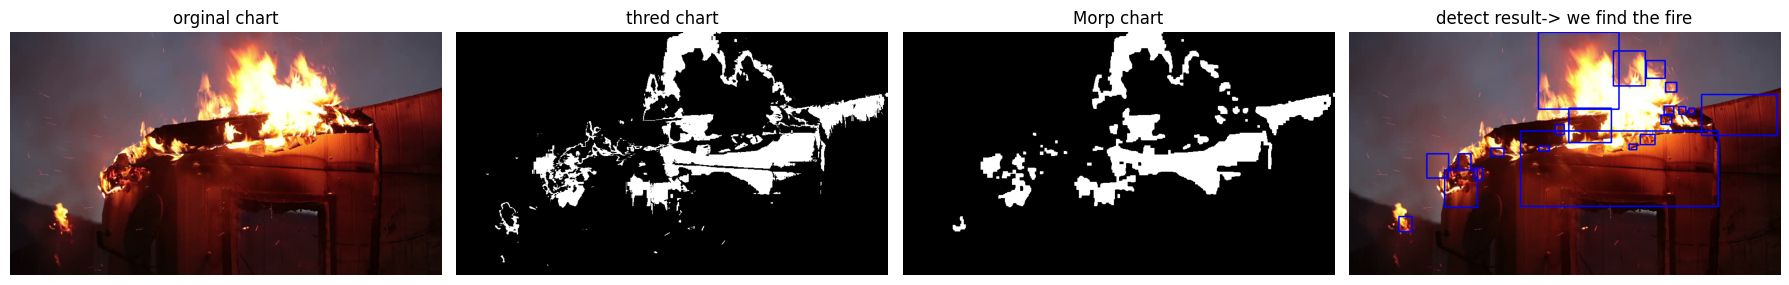

In [45]:
visual_CCA_result('./CV_FIRE/data/fire/fire.jpg')

#### Section3: Gabor Method:

In [46]:
def gabor_filter(gray_spec_area,ksize=21,sigma=5.0,lambd=10.0,gamma=0.5,psi=0,):


    theta_list = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

    features = []
    for theta in theta_list:
        gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
        filtered = cv2.filter2D(gray_spec_area, cv2.CV_32F, gabor_kernel)
        mean_val = filtered.mean()
        std_val = filtered.std()
        features.append(mean_val)
        features.append(std_val)

    return features

In [47]:
def Gabor_CCA(img,mor_img,threshold,gabor_threshold = 5):

    num_labels, labels, stats, centro = cv2.connectedComponentsWithStats(mor_img, connectivity=8)

    for i in range(1, num_labels): 
        x, y, w, h, area = stats[i]
        if area > threshold:
            spec_area = img[y:y+h, x:x+w] 
            gray_spec_area = cv2.cvtColor(spec_area, cv2.COLOR_BGR2GRAY)
            gabor_fe = gabor_filter(gray_spec_area)
            avg = np.mean(gabor_fe)

            if avg >= gabor_threshold:
                return True
    return False


In [48]:
def detect_fire_in_image(image_path, area_threshold=100):
    image,hsv_image  = read_to_hsv(image_path)
    thred_image = threshold_process_opt(hsv_image)
    morp_image = Morphological_operation_opt(thred_image)
    return Gabor_CCA(image,morp_image,area_threshold,180.0)

In [49]:
evaluate_fire_detection(data_dir='./CV_FIRE/data')

total number of picture: 206
TP: 106 TN: 33 FP: 63 FN: 4
Accuracy: 0.6747572815533981
Precision:  0.6272189349112426
Recall:  0.9636363636363636
F1-score:  0.7598566308243728


0.7598566308243728

#### This part we will find the best performance

In [50]:
import itertools

In [51]:
def detect_fire_in_image(image_path, area_threshold=100,gabor_threshold = 100):
    image,hsv_image  = read_to_hsv(image_path)
    thred_image = threshold_process_opt(hsv_image)
    morp_image = Morphological_operation_opt(thred_image)
    return Gabor_CCA(image,morp_image,area_threshold,gabor_threshold)

In [52]:
#the reason we revise this function is that we need to find the peak performance of the gabor way.
def evaluate_fire_detection_gabor_best(data_dir='data',area_threshold = 100,gabor_threshold = 100):


    fire_dir = os.path.join(data_dir, 'fire')
    no_fire_dir = os.path.join(data_dir, 'no_fire')

    TP = 0 
    TN = 0 
    FP = 0 
    FN = 0  

    if os.path.isdir(fire_dir):
        for filename in os.listdir(fire_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(fire_dir, filename)
                has_fire = detect_fire_in_image(image_path,area_threshold,gabor_threshold) 

                if has_fire:
                    TP += 1
                else:
                    FN += 1
    else:
        print("cannot find dir", fire_dir)


    if os.path.isdir(no_fire_dir):
        for filename in os.listdir(no_fire_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(no_fire_dir, filename)
                has_fire = detect_fire_in_image(image_path,area_threshold,gabor_threshold)
                if has_fire:
                    FP += 1
                else:
                    TN += 1
    else:
        print("cannot find dir", no_fire_dir)
    total_images = TP + TN + FP + FN
    if total_images == 0:
        return
    
    accuracy = (TP + TN) / total_images

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    if (precision + recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    # print("total number of picture:", total_images)
    # print("TP:", TP, "TN:", TN, "FP:", FP, "FN:", FN)
    # print("Accuracy:" ,accuracy)
    # print("Precision: ",precision)
    # print("Recall: ",recall)
    # print("F1-score: ",f1_score)

    return f1_score

In [53]:
def find_best_performance():
    area_thresholds_list = [50, 100, 150, 200]
    gabor_thre_list = [10,30,50,80,100,130,160,200,250,300,350,400,450,500]
    best_score = 0
    best_params = None

    for area_thresholds, gabor_thresholds in itertools.product(area_thresholds_list, gabor_thre_list):
        f1_score = evaluate_fire_detection_gabor_best(data_dir='./CV_FIRE/data',area_threshold = area_thresholds,gabor_threshold = gabor_thresholds)
        print(f1_score)
        if f1_score > best_score:
            best_score = f1_score
            best_params = (area_thresholds,gabor_thresholds)
    print("best score", best_score)
    print("best param",best_params)
    

In [54]:
find_best_performance()

0.7508771929824561
0.7508771929824561
0.7508771929824561
0.7508771929824561
0.7508771929824561
0.7508771929824561
0.7535211267605634
0.7561837455830388
0.7526881720430108
0.7418181818181818
0.7407407407407406
0.7258687258687259
0.7200000000000001
0.7112970711297071
0.7544483985765125
0.7544483985765125
0.7544483985765125
0.7544483985765125
0.7544483985765125
0.7544483985765125
0.7571428571428571
0.7598566308243728
0.7563636363636362
0.7407407407407406
0.739622641509434
0.7244094488188975
0.6970954356846473
0.6812227074235808
0.7709090909090909
0.7709090909090909
0.7709090909090909
0.7709090909090909
0.7709090909090909
0.7709090909090909
0.7737226277372263
0.7765567765567766
0.7675276752767527
0.7490636704119851
0.7404580152671757
0.7250996015936255
0.6919831223628692
0.6636771300448431
0.7737226277372263
0.7737226277372263
0.7737226277372263
0.7737226277372263
0.7737226277372263
0.7737226277372263
0.7765567765567766
0.7794117647058824
0.7703703703703704
0.7575757575757576
0.75193798449

#### Gabor part chart:

In [55]:
def Gabor_CCA_chart(img,mor_img,rgb_img,threshold,gabor_threshold = 5):

    num_labels, labels, stats, centro = cv2.connectedComponentsWithStats(mor_img, connectivity=8)
    output_image = rgb_img.copy()
    fire_detected = False
    for i in range(1, num_labels): 
        x, y, w, h, area = stats[i]
        if area > threshold:
            spec_area = img[y:y+h, x:x+w] 
            gray_spec_area = cv2.cvtColor(spec_area, cv2.COLOR_BGR2GRAY)
            gabor_fe = gabor_filter(gray_spec_area)
            avg = np.mean(gabor_fe)
            print(avg)
            if avg >= gabor_threshold:
                fire_detected = True
                cv2.rectangle(output_image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    return fire_detected,output_image

In [56]:
def visual_gabor_CCA_result(image_path, area_threshold=100,gabor_threshold = 5):

    image,rgb_img,hsv_img = rgb_hsv_chart(image_path)
    
    thred_image = threshold_process_opt(hsv_img)
    morp_image = Morphological_operation_opt(thred_image)

    fire_detected,cca_img = Gabor_CCA_chart(image,morp_image,rgb_img,area_threshold,gabor_threshold)
    
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    
    axs[0].imshow(rgb_img)
    axs[0].set_title("orginal chart")
    axs[0].axis("off")
    
    axs[1].imshow(thred_image, cmap='gray')
    axs[1].set_title("thred chart")
    axs[1].axis("off")
    
    axs[2].imshow(morp_image, cmap='gray')
    axs[2].set_title("Morp chart")
    axs[2].axis("off")

    title = "detect result-> we find the fire" if fire_detected else "we don't find the fire"
    axs[3].imshow(cca_img)
    axs[3].set_title(title)
    axs[3].axis("off")
    
    plt.tight_layout()
    plt.show()

548.8905
618.0556
571.74646
663.6426
271.30457
752.89886
760.5879
818.43555
315.70306
689.736
470.21188
420.3792
854.4295
902.1457
645.7828
872.2616
519.1234
601.5022
493.3031
645.8447
659.4039


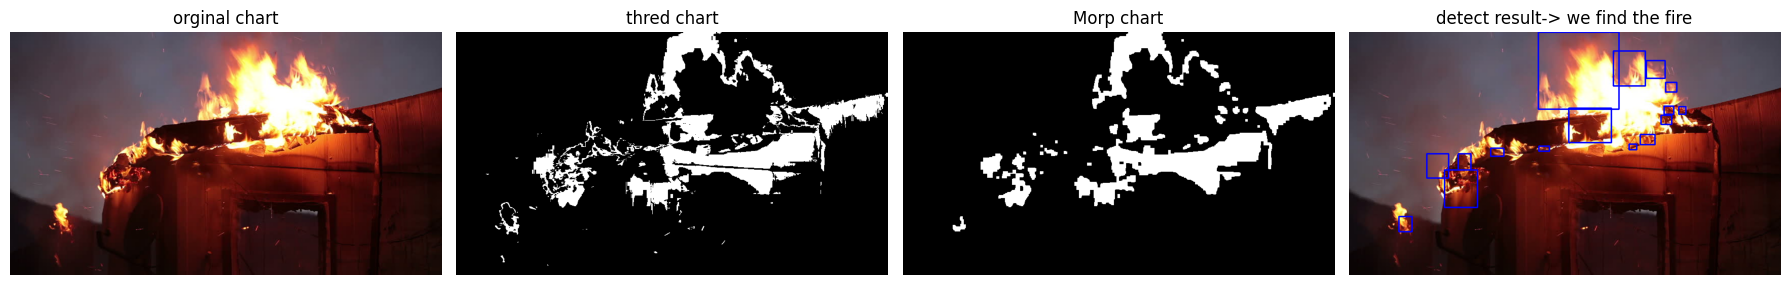

In [57]:
visual_gabor_CCA_result('./CV_FIRE/data/fire/fire.jpg',100,500)

#### DFT

In [58]:
def DFT_threshold(process_area,freq_threshold = 80):
    dft_img = cv2.dft(np.float32(process_area), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift_img = np.fft.fftshift(dft_img)

    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift_img[:,:,0], dft_shift_img[:,:,1]) + 1e-5)

    mean_val = np.mean(magnitude_spectrum)
    return mean_val >= freq_threshold

In [59]:
def DFT_CCA(oringinal_img,morp_img,threshold, freq_threshold):
    num_labels, labels, stats, centro = cv2.connectedComponentsWithStats(morp_img, connectivity=8)

    for i in range(1, num_labels):  
        x, y, w, h, area = stats[i]
        if area > threshold:

            specific_area = oringinal_img[y:y+h, x:x+w] 
            gray_area = cv2.cvtColor(specific_area, cv2.COLOR_BGR2GRAY)

            is_freq_ok = DFT_threshold(gray_area, freq_threshold)
            if is_freq_ok:
                return True
    return False    

In [60]:
def detect_fire_in_image(image_path, area_threshold=100):
    image,hsv_image  = read_to_hsv(image_path)
    thred_image = threshold_process_opt(hsv_image)
    morp_image = Morphological_operation_opt(thred_image)
    return DFT_CCA(image,morp_image,area_threshold,100.0)

In [61]:
evaluate_fire_detection(data_dir='./CV_FIRE/data')

total number of picture: 206
TP: 100 TN: 45 FP: 51 FN: 10
Accuracy: 0.7038834951456311
Precision:  0.6622516556291391
Recall:  0.9090909090909091
F1-score:  0.7662835249042146


0.7662835249042146

In [103]:
#realiza multi-scale
def detect_fire_in_image(image_path, area_threshold=100,scales = [0.2,0.5,1.0,2.0]):
    image,_  = read_to_hsv(image_path)
    for scale in scales:
        if scale != 1.0:
            new_width = int(image.shape[1] * scale)
            new_height = int(image.shape[0] * scale)
            resized_img = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        else:
            resized_img = image
        hsv_image = cv2.cvtColor(resized_img, cv2.COLOR_BGR2HSV)
        thred_image = threshold_process_opt(hsv_image)
        morp_image = Morphological_operation_opt(thred_image)
        if(DFT_CCA(resized_img,morp_image,area_threshold,100.0)):
            return True
    return False

In [104]:
evaluate_fire_detection(data_dir='./CV_FIRE/data')

total number of picture: 206
TP: 100 TN: 38 FP: 58 FN: 10
Accuracy: 0.6699029126213593
Precision:  0.6329113924050633
Recall:  0.9090909090909091
F1-score:  0.746268656716418


0.746268656716418

#### Section 5 Superpixel:

In [62]:
from skimage.segmentation import slic, mark_boundaries
from skimage.color import rgb2lab

In [63]:
def red_thresh(hsv):
    mean_h, mean_s, mean_v = hsv
    # is_red = ((0 <= mean_h <= 20) and mean_s>=100 and mean_v>=120) or ((160 <= mean_h <= 180) and mean_s>=100 and mean_v>=120)
    is_red = (0 <= mean_h <= 20) or (160 <= mean_h <= 180) 
    return is_red

In [64]:
def gabor_check(image,gabor_threshold):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    result = gabor_filter(gray_image)
    return np.mean(result) > gabor_threshold

In [65]:
def ft_check(image,ft_threshold):
    gray_image  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dft = cv2.dft(np.float32(gray_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    mag = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
    mag_spectrum = 20 * np.log(mag + 1.0)
    return np.mean(mag_spectrum) >= ft_threshold

In [66]:
def Superpixel_thred_operation(image_path,n_segments,compact,gabor_threshold = 100,ft_thread = 60):
    image = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    seg = slic(rgb_img,n_segments,compact,0)
    
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    init_thred = np.zeros(image.shape[:2], dtype=np.uint8)
    pixel_id = np.unique(seg)
    for i in pixel_id:
        mask = (seg == i)
        mean_h = np.mean(hsv_img[:,:,0][mask])
        mean_s = np.mean(hsv_img[:,:,1][mask])
        mean_v = np.mean(hsv_img[:,:,2][mask])

        if(red_thresh((mean_h,mean_s,mean_v))):
            ys, xs = np.where(mask)
            min_y, max_y = ys.min(), ys.max()
            min_x, max_x = xs.min(), xs.max()

            spe_area = image[min_y:max_y+1, min_x:max_x+1]

            if(gabor_check(spe_area,gabor_threshold) and ft_check(spe_area,ft_thread)):
                init_thred[mask] = 255

    return init_thred

In [67]:
def detect_fire_in_image(image_path, area_threshold=100):
    thred_image = Superpixel_thred_operation(image_path,150,20)

    # print(thred_image)
    morp_image = Morphological_operation_opt(thred_image)
    return CCA(morp_image,area_threshold)

In [68]:
evaluate_fire_detection(data_dir='./CV_FIRE/data')

total number of picture: 206
TP: 35 TN: 87 FP: 9 FN: 75
Accuracy: 0.5922330097087378
Precision:  0.7954545454545454
Recall:  0.3181818181818182
F1-score:  0.45454545454545453


0.45454545454545453

#### find the best performance

In [69]:
# def detect_fire_in_image(image_path, area_threshold=100,n_segments = 100,compact = 20,gabor_threshold=100,ft_thread = 80):
#     thred_image = Superpixel_thred_operation(image_path,n_segments,compact,gabor_threshold,ft_thread)

#     # print(thred_image)
#     morp_image = Morphological_operation(thred_image)
#     return CCA(morp_image,area_threshold)

In [70]:
# #the reason we revise this function is that we need to find the peak performance of the gabor way.
# def evaluate_fire_detection_sp_best(data_dir='data',area_threshold = 100,gabor_threshold = 100,ft_thread = 60,n_segments = 100,compact = 20):


#     fire_dir = os.path.join(data_dir, 'fire')
#     no_fire_dir = os.path.join(data_dir, 'no_fire')

#     TP = 0 
#     TN = 0 
#     FP = 0 
#     FN = 0  

#     if os.path.isdir(fire_dir):
#         for filename in os.listdir(fire_dir):
#             if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
#                 image_path = os.path.join(fire_dir, filename)
#                 has_fire = detect_fire_in_image(image_path,area_threshold,n_segments,compact,gabor_threshold,ft_thread) 

#                 if has_fire:
#                     TP += 1
#                 else:
#                     FN += 1
#     else:
#         print("cannot find dir", fire_dir)


#     if os.path.isdir(no_fire_dir):
#         for filename in os.listdir(no_fire_dir):
#             if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
#                 image_path = os.path.join(no_fire_dir, filename)
#                 has_fire = detect_fire_in_image(image_path,area_threshold,n_segments,compact,gabor_threshold,ft_thread)
#                 if has_fire:
#                     FP += 1
#                 else:
#                     TN += 1
#     else:
#         print("cannot find dir", no_fire_dir)
#     total_images = TP + TN + FP + FN
#     if total_images == 0:
#         return
    
#     accuracy = (TP + TN) / total_images

#     precision = TP / (TP + FP) if (TP + FP) else 0
#     recall = TP / (TP + FN) if (TP + FN) else 0
#     if (precision + recall) == 0:
#         f1_score = 0
#     else:
#         f1_score = 2 * (precision * recall) / (precision + recall)

#     return f1_score

In [71]:
# def find_best_performance_sp():
#     area_thresholds_list = [50, 100, 150, 200]
#     gabor_thre_list = [10,30,50,80,100,130,160,200,250,300,350,400,450,500]
#     ft_list = [30,50,80,110,130,150]
#     components_list = [100,150,200,300,250]
#     compac_list = [5,10,15,20,30,40]
#     best_score = 0
#     best_params = None

#     for area_thresholds, gabor_thresholds,ft,component,compac in itertools.product(area_thresholds_list, gabor_thre_list,ft_list,components_list,compac_list):
#         f1_score = evaluate_fire_detection_sp_best(data_dir='./CV_FIRE/data',area_threshold = area_thresholds,gabor_threshold = gabor_thresholds,ft_thread=ft,n_segments=component,compact=compac)
#         print(f1_score)
#         if f1_score > best_score:
#             best_score = f1_score
#             best_params = (area_thresholds,gabor_thresholds,ft,component,compac)
#     print("best score", best_score)
#     print("best param",best_params)
    

#### Section 6 SVM

In [72]:
from skimage.feature import hog
from sklearn.svm import SVC

In [73]:
def hog_op(image, img_size=(128, 128)):
    image = cv2.resize(image, img_size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), block_norm='L2-Hys')
    return hog_features

In [74]:
def pro_data(category_os,labels_type,target_size = (128,128)):
    images = []
    labels = []
    if os.path.isdir(category_os):
        for fname in os.listdir(category_os):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(category_os, fname)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img_1d = hog_op(img, target_size)
                images.append(img_1d)
                labels.append(labels_type)

    return images,labels

In [75]:

def load_data(data_dir, img_size = (128,128)):
    fire_dir = os.path.join(data_dir, 'fire')
    no_fire_dir = os.path.join(data_dir, 'no_fire')

    images,labels = pro_data(fire_dir,1)

    images_2,labels_2 = pro_data(no_fire_dir,0)


    images_final = np.vstack((images, images_2))
    labels_final = np.hstack((labels, labels_2))

    image = np.array(images_final, dtype=np.float32)
    label = np.array(labels_final, dtype=np.int32)

    return image,label


In [76]:
def classification_svm(data_dir):

    image, label = load_data(data_dir=data_dir)

    X_train, X_test, y_train, y_test = train_test_split(image, label, test_size=0.2, random_state=42)

    model = SVC(kernel='rbf', C=1.0, gamma='auto')  
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("acc",acc)
    print("prec",prec)
    print("rec",rec)
    print("f1",f1)

In [77]:
classification_svm('./CV_FIRE/data')

acc 0.47619047619047616
prec 0.47619047619047616
rec 1.0
f1 0.6451612903225806


#### Section 7 CNN

In [78]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),                             
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [79]:
def pro_data(category_os,labels_type,target_size = (128,128)):
    images = []
    labels = []
    if os.path.isdir(category_os):
        for fname in os.listdir(category_os):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(category_os, fname)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(labels_type)

    return images,labels

In [80]:
def load_data(data_dir='data', target_size=(128, 128)):
    fire_dir = os.path.join(data_dir, 'fire')
    no_fire_dir = os.path.join(data_dir, 'no_fire')

    images,labels = pro_data(fire_dir,1)
    images_2,labels_2 = pro_data(no_fire_dir,0)

    images_final = np.vstack((images, images_2))
    labels_final = np.hstack((labels, labels_2))

    images_final = np.array(images_final, dtype=np.float32)
    labels_final = np.array(labels_final, dtype=np.int64)

    images_final /= 255.0
    images_final = np.transpose(images_final, (0, 3, 1, 2))
    return images_final,labels_final

In [81]:
def classification_cnn(data_dir, target_size=(128, 128), epochs=5, batch_size=16):
    images, labels = load_data(data_dir, target_size)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    X_test_tensor  = torch.tensor(X_test)
    y_test_tensor  = torch.tensor(y_test)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    print("Using device: ",device)

    model = SimpleCNN(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.numpy())

    acc  = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds, zero_division=0)
    rec  = recall_score(all_targets, all_preds, zero_division=0)
    f1   = f1_score(all_targets, all_preds, zero_division=0)

    print("acc",acc)
    print("prec",prec)
    print("rec",rec)
    print("f1",f1)

In [82]:
classification_cnn(data_dir='./CV_FIRE/data', target_size=(128, 128), epochs=12, batch_size=16)

Using device:  cpu
Epoch [1/12], Loss: 0.7539
Epoch [2/12], Loss: 0.4854
Epoch [3/12], Loss: 0.4125
Epoch [4/12], Loss: 0.3355
Epoch [5/12], Loss: 0.2443
Epoch [6/12], Loss: 0.1426
Epoch [7/12], Loss: 0.1474
Epoch [8/12], Loss: 0.0831
Epoch [9/12], Loss: 0.0761
Epoch [10/12], Loss: 0.0632
Epoch [11/12], Loss: 0.0391
Epoch [12/12], Loss: 0.0274
acc 0.7857142857142857
prec 0.7037037037037037
rec 0.95
f1 0.8085106382978724


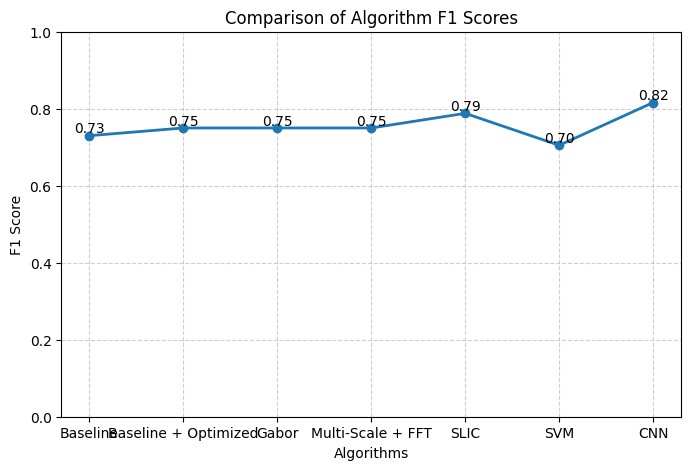

In [83]:
def plot_f1_scores(algorithms, f1_scores):
    plt.figure(figsize=(8, 5))
    plt.plot(algorithms, f1_scores, marker='o', linestyle='-', linewidth=2, markersize=6)
    
    plt.xlabel("Algorithms")
    plt.ylabel("F1 Score")
    plt.title("Comparison of Algorithm F1 Scores")
    
    plt.ylim(0, 1)  
    
    for i, txt in enumerate(f1_scores):
        plt.text(algorithms[i], f1_scores[i], f"{txt:.2f}", ha='center', va='bottom', fontsize=10)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

algorithms = ['Baseline', 'Baseline + Optimized', 'Gabor', 'Multi-Scale + FFT', 'SLIC','SVM','CNN']
f1_scores = [0.73,0.75,0.75,0.75,0.788,0.705,0.816]

plot_f1_scores(algorithms, f1_scores)

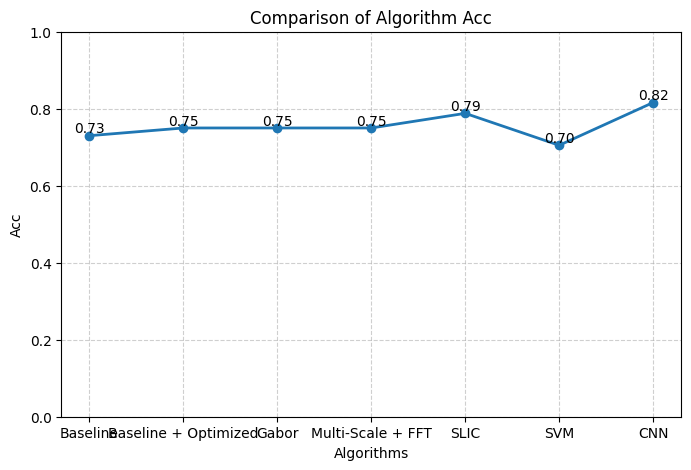

In [84]:
def plot_f1_scores(algorithms, f1_scores):
    plt.figure(figsize=(8, 5))
    plt.plot(algorithms, f1_scores, marker='o', linestyle='-', linewidth=2, markersize=6)
    
    plt.xlabel("Algorithms")
    plt.ylabel("Acc")
    plt.title("Comparison of Algorithm Acc")
    
    plt.ylim(0, 1) 
    
    for i, txt in enumerate(f1_scores):
        plt.text(algorithms[i], f1_scores[i], f"{txt:.2f}", ha='center', va='bottom', fontsize=10)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

algorithms = ['Baseline', 'Baseline + Optimized', 'Gabor', 'Multi-Scale + FFT', 'SLIC','SVM','CNN']
accu = [0.6,0.66,0.67,0.67,0.718,0.553,0.786]

plot_f1_scores(algorithms, f1_scores)

#### Extra: Optical way

In [ ]:
def process_video(video_path='fire_video.mp4'):
    capture_obj = cv2.VideoCapture(video_path)
    ret, previous_frame = capture_obj.read()
    previous_gray_img = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    return capture_obj,ret,previous_frame,previous_gray_img

In [86]:
def optical_compute(frame,capture_obj,previous_gray_img,motion_threshold):

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(previous_gray_img, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flow_x = flow[..., 0]
    flow_y = flow[..., 1]
    mag, ang = cv2.cartToPolar(flow_x, flow_y)
    motion_mask = np.uint8((mag > motion_threshold) * 255)
    return gray,motion_mask

In [ ]:
def write_video(capture_obj):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_fps = capture_obj.get(cv2.CAP_PROP_FPS)
    width = int(capture_obj.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture_obj.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter('fire_output.mp4', fourcc, out_fps, (width, height))
    return out

In [88]:
def optical_CCA(frame,mor_image,area_threshold,gabor_threshold,fft_threshold):
    num_labels, labels, stats, centro = cv2.connectedComponentsWithStats(mor_image, connectivity=8)
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area >= area_threshold:
            spec_area = frame[y:y+h, x:x+w]
            if gabor_check(spec_area, gabor_threshold) and ft_check(spec_area, fft_threshold):
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(frame, 'Fire', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
    return frame

In [ ]:
def optical_detection(
    video_path='fire_video.mp4',
    motion_threshold=2.0, 
    area_threshold=200,    
    gabor_threshold=5.0, 
    fft_threshold=80.0
):
    capture_obj,ret,previous_frame,previous_gray_img = process_video(video_path)
    

    out = write_video(capture_obj)

    while True:
        ret, frame = capture_obj.read()
        if not ret:
            break
        gray,motion_mask  = optical_compute(frame,capture_obj,previous_gray_img,motion_threshold=motion_threshold)

    
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        thred_img = threshold_process_opt(hsv)
        mo_th_img = cv2.bitwise_and(thred_img, motion_mask)

        mor_img = Morphological_operation_opt(mo_th_img)


        frame = optical_CCA(frame,mor_img,area_threshold,gabor_threshold,fft_threshold)
        previous_gray_img = gray

        cv2.imshow("Fire Detect", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

        out.write(frame)

    capture_obj.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
optical_detection(video_path="./CV_FIRE/fire_video.mp4",motion_threshold=2.0,area_threshold=500,gabor_threshold=5.0, fft_threshold=80.0, )